# Prepare data

## Import libraries

In [ ]:
import os
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import random
import uuid
import datetime
import pypdfium2 as pdfium
import fnmatch

## Extract pages from pdf document

In [ ]:
# From directory with pdf document save all pages as JPG file
# Change `directory` if you want use this sample in your project
directory = "/home/pan_pawel/Documents/GitHub/AECVision/images/test pypdfium/"
folder = os.walk(directory)

for froot, dirs, files in folder:
    for file in files:
        file_path = os.path.join(froot, file)
        pdf = pdfium.PdfDocument(file_path)
        n_pages = len(pdf)
        
        for page_number in range(n_pages):
            page = pdf[page_number]
            # page.set_rotation(90) # if rotation needed
            pil_image = page.render(scale=random.uniform(4.7, 5.8)).to_pil() # uniform(X.X, Y.Y) is scale
            pil_image.save(f"{froot}{file}{page_number+1}.jpg")

## Crop images to 1280x1280 format

### First I crop images to 2560x2560 because i don't want to loose image quality and generate a lot images with high zoom

In [ ]:
def to_2560_format(h, w):
    # For random crop because buildings are similar on sheets by floor level
    random_number = random.randrange(100,600)
    # Return pixel numbers for crop
    return ((w-1)*2560+random_number,(h-1)*2560+random_number, w*2560+random_number, h*2560+random_number)


Image.MAX_IMAGE_PIXELS = 1000000000 

# Change `directory` if you want use this sample in your project
directory = "original_images/test pypdfium/test/"
folder = os.walk(directory)

# Create "splited" folder if doesn't exist in directory
output_path = os.path.join(directory, "splited")
try:
    os.makedirs(output_path) 
except:
    pass

for froot, dirs, files in folder:
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(froot, file)
            output_path = os.path.join(froot, "splited")
            img = Image.open(file_path) # Image
            
            # Calculate how many croped images could be created from .jpg file
            w, h = img.size
            w_crop_iterations = int(w/2560)
            h_crop_iterations = int(h/2560)
            
            # Crop image
            for h_multiplication, h_iteration in enumerate(range(h_crop_iterations), 1):
                for w_multiplication, w_iteration in enumerate(range(w_crop_iterations), 1):
                    crop_area = to_2560_format(h_multiplication, w_multiplication)
                    
                    # Print multiplication and crop area to check results
                    print("h mult {} w mult {}".format(h_multiplication, w_multiplication))
                    print(crop_area)

                    # Crop image
                    img_crop = img.crop(crop_area)
                    
                    # Resize to 1280x1280 format
                    img_crop.thumbnail((1280, 1280))
                    crop_save = os.path.join(output_path, "{}_{}_{}.jpg".format(file[:-5:], h_multiplication, w_multiplication))
                    img_crop.save(crop_save)

### Add sufix to mark images for preannotation

In [ ]:
# Python program to rename all file names in your directory

# Change `directory` if you want use this sample in your project
directory = "/home/pan_pawel/Documents/GitHub/AECVision/images/test/splited/old/"
os.chdir(directory)

for count, f in enumerate(fnmatch.filter(os.listdir(), "*.jpg")):
	image_name = "{}{:-%Y%m%d%H%M%S}".format(str(uuid.uuid4().hex), datetime.date.today())
	f_name, f_ext = os.path.splitext(f)
	f_name = image_name + str(count) + "-preannotation_1" # Add sufix change if you want add your own
	new_name = f"{f_name}{f_ext}"
	os.rename(f, new_name)

### Rename images and txt annotation from folders

I renamed images because export files from Label-Studio had different names. This is not necessary!

In [ ]:
# Change `PATH` if you want use this sample in your project
PATH = "/home/pan_pawel/Documents/GitHub/AECVision/small_dataset_rar/project-4-at-2023-05-18-19-31-7c22f4aa/"

for root, dir, files in os.walk(os.path.join(PATH, "images/")):
    for file in files:
        new_name = str(uuid.uuid4().hex)+ str(datetime.date.today())
        image_path = os.path.join(PATH, "images", file)
        image_rename = os.path.join(PATH, "images", new_name)
        annotation_path = os.path.join(PATH, "labels", "{}.txt".format(file[:-4:]))
        annotation_rename = os.path.join(PATH, "labels", new_name)
        os.rename(image_path, image_rename)
        os.rename(annotation_path, annotation_rename)

## Split data

Before spliting you need to export your images and labels in yolo format from Label-Studio.
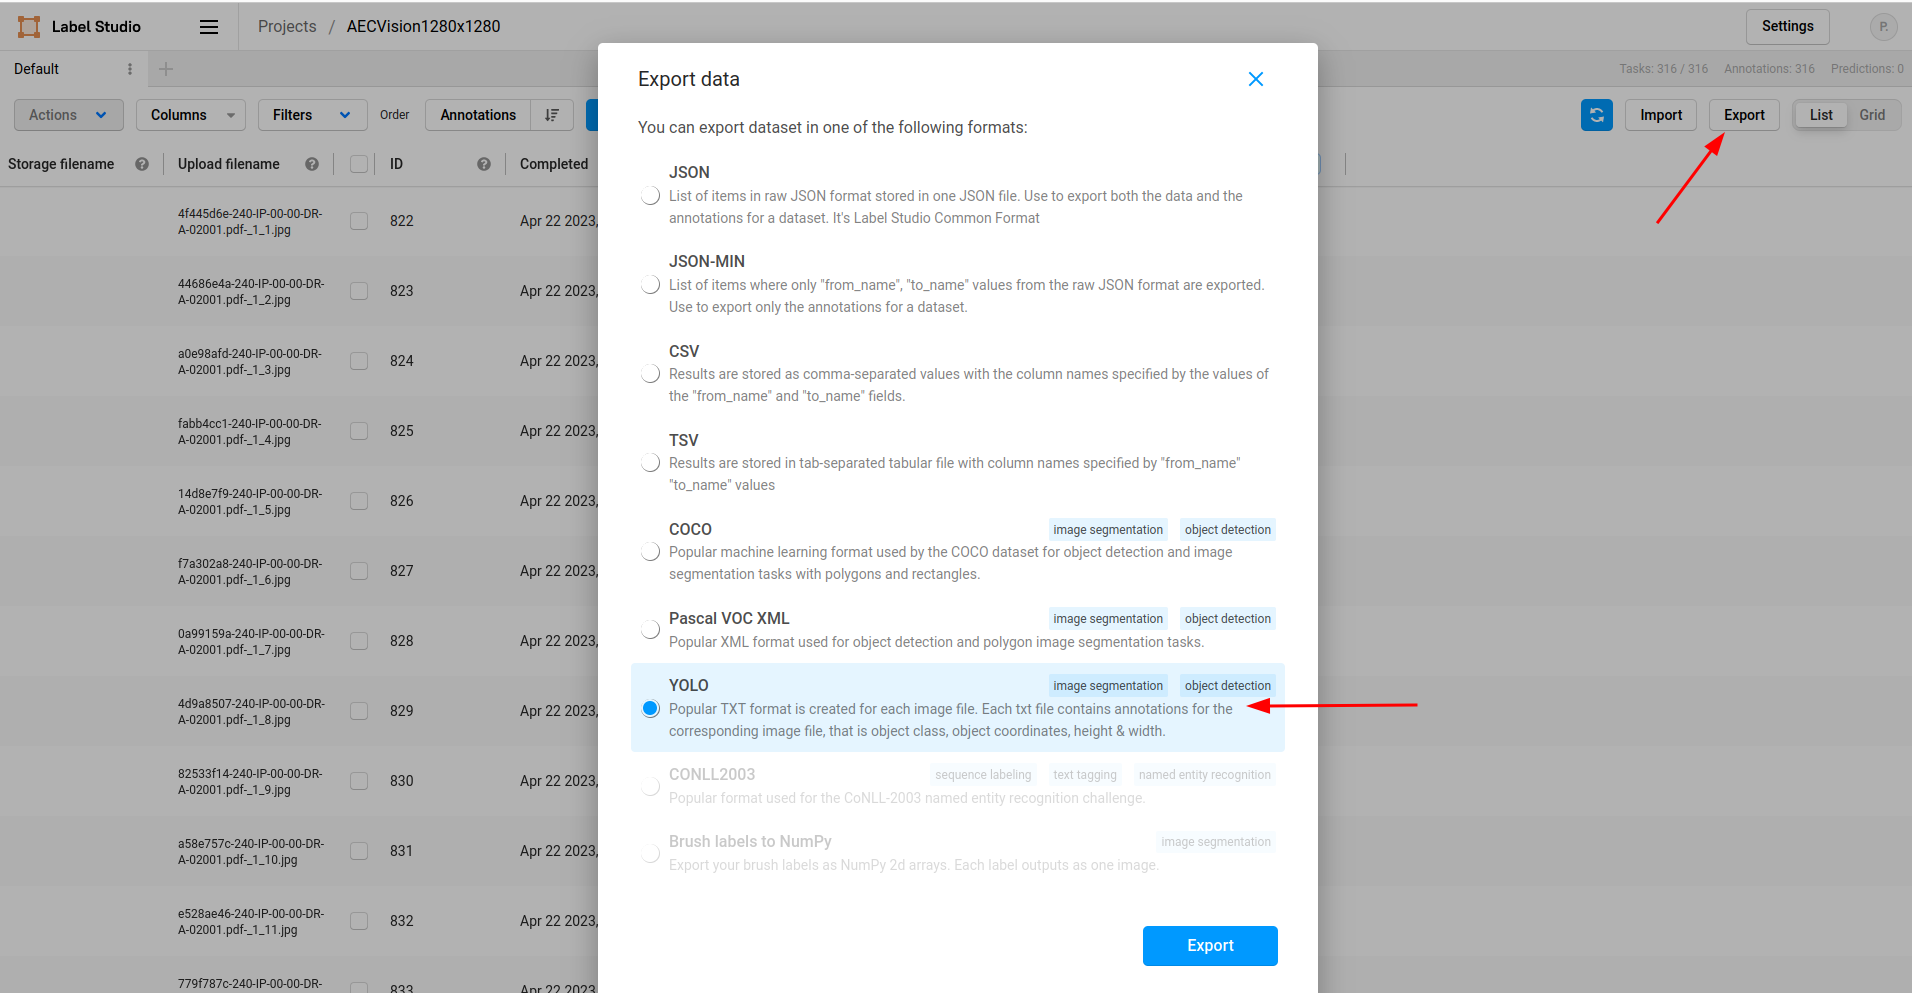

### Split images

In [ ]:
# Get all paths to your images files and text files
# Change `PATH` if you want use this sample in your project
PATH = "/home/pan_pawel/Documents/GitHub/AECVision/small_dataset_rar/project-4-at-2023-05-18-19-31-7c22f4aa/"
img_paths = glob.glob(PATH+"/images/*")
txt_paths = glob.glob(PATH+"/labels/*")

# Random seed comment this if you don't want to use this in your example
random.seed(43)

# Split to train and val/test 
# Calculate number of files for training, validation/test
data_size = len(img_paths)
r = 0.8
train_size = int(data_size * 0.8)

# Shuffle to train and val/test
img_txt = list(zip(img_paths, txt_paths))
random.shuffle(img_txt)
img_paths, txt_paths = zip(*img_txt)

# Split them to train and val/test
train_img_paths = img_paths[:train_size]
train_txt_paths = txt_paths[:train_size]

valid_test_img_paths = img_paths[train_size:]
valid_test_txt_paths = txt_paths[train_size:]

# Split to val and test
# Calculate number of files for validation and test
data_size = len(valid_test_img_paths)
r = 0.5
test_size = int(data_size * 0.5)

# Shuffle to val and test
img_txt = list(zip(valid_test_img_paths, valid_test_txt_paths))
random.shuffle(img_txt)
valid_test_img_paths, valid_test_txt_paths = zip(*img_txt)

# Now split them to val and test
test_img_paths = valid_test_img_paths[:test_size]
test_txt_paths = valid_test_txt_paths[:test_size]

valid_img_paths = valid_test_img_paths[test_size:]
valid_txt_paths = valid_test_txt_paths[test_size:]

# Move them to train, val and test folders
# Change `PATH` if you want use this sample in your project
PATH = "/home/pan_pawel/Documents/GitHub/AECVision/small_dataset_rar/project-4-at-2023-05-18-19-31-7c22f4aa/"
train_images_folder = PATH+'/images/training/'
train_label_folder = PATH+'/labels/training/'
valid_images_folder = PATH+'/images/validation/'
valid_label_folder = PATH+'/labels/validation/'
test_images_folder = PATH+'/images/test/'
test_label_folder = PATH+'/labels/test/'

try:
    os.makedirs(train_images_folder)
    os.makedirs(train_label_folder)
    os.makedirs(valid_images_folder)
    os.makedirs(valid_label_folder)
    os.makedirs(test_images_folder)
    os.makedirs(test_label_folder)
except:
    pass

def copy(paths, folder):
    for p in paths:
        os.rename(p, (folder+"{}".format(os.path.basename(p))))

copy(train_img_paths, train_images_folder)
copy(valid_img_paths, valid_images_folder)
copy(test_img_paths, test_images_folder)

### Split labels

In [ ]:
# This code split labels by image names in folder
# Get path to images. 'PATH' is set in previous cell
img_test_paths = [os.path.splitext(filename)[0] for filename in glob.glob(PATH+'/images/test/*')]
img_training_paths = [os.path.splitext(filename)[0] for filename in glob.glob(PATH+'/images/training/*')]
img_validation_paths = [os.path.splitext(filename)[0] for filename in glob.glob(PATH+'/images/validation/*')]

# Set path to labels
train_label_folder = PATH+'/labels/training/'
valid_label_folder = PATH+'/labels/validation/'
test_label_folder = PATH+'/labels/test/'

def basename(i):
    return os.path.basename(i)

# Create list of files
img_test_paths = list(map(basename, img_test_paths))
img_training_paths = list(map(basename, img_training_paths))
img_validation_paths = list(map(basename, img_validation_paths))

# Loop to move files to folders
for file in txt_paths:
    file_name = basename(file)
    
    if file_name[:-4:] in img_training_paths:
        os.rename(file, (train_label_folder+"{}".format(file_name[:-4:])))
    elif file_name[:-4:] in img_validation_paths:
        os.rename(file, (valid_label_folder+"{}".format(file_name[:-4:])))
    elif file_name[:-4:] in img_test_paths:
        os.rename(file, (test_label_folder+"{}".format(file_name[:-4:])))
    else:
        pass

# Augmentation

## Import libraries

In [ ]:
import albumentations as A
import cv2
import uuid

Define class and transformer

In [ ]:
# Model classes 
class_names = ["bath",
"dishwasher / washing machine",
"door",
"furniture",
"refrigerator",
"sink",
"stairs",
"stove",
"table",
"wall",
"wc",
"window"]

# Define transform pipeline
transform = A.Compose([
    A.RandomResizedCrop(width=1280, height=1280, scale=(0.2,2)),
    A.HorizontalFlip(p=0.5)
], bbox_params=A.BboxParams(format='yolo'))

In [ ]:
# Import labels from txt
def import_txt_annotations(txt_file_path=""):
    # Create list to store data
    bboxes_lists =[]
    class_labels = []
    bbox_class_list =[]
    
    with open(txt_file_path) as f:
        for line in f:
            stripped_line = line.strip()
            line_list = stripped_line.split()
            bbox_class= [float(i) for i in line_list[1:5]]
            bbox_class = bbox_class + [int(line_list[0])]
            
            class_labels.append(int(line_list[0]))
            bboxes_lists.append(float(i) for i in line_list[1:5])
            bbox_class_list.append(bbox_class)
    return bboxes_lists, class_labels, bbox_class_list

# Save new labels after augmentation
def save_augmented_image_txt(image_path="", txt_path="", transformed_image=[], transformed_bboxes=[]):
    # Create unique number
    uuid_number = str(uuid.uuid4().hex)+ str(datetime.date.today())
    
    # Save new image
    cv2.imwrite("{}/{}.jpg".format(image_path, uuid_number), transformed_image)

    # Save new label
    with open("{}/{}.txt".format(txt_path, uuid_number), "w") as f:
        for line in transformed_bboxes:
            print(line[4])
            f.write(str(line[4]))
            for coordinates in line[0:4]:
                print(coordinates)
                f.write(" "+str(coordinates))
            f.write("\n")

In [ ]:
# Change folder path if you want to use this in your case
# I save files in new folder because i want to check correctness
current_path = os.path.abspath(os.getcwd())
augmented_image_path = os.path.join(current_path, "small_dataset_augmented/images/test/")
augmented_txt_path = os.path.join(current_path, "small_dataset_augmented/labels/test/")

# This function i use for all data sets (train/test/validation) by change path "small_dataset/images/test" and "small_dataset/labels/test/{}.txt"
for root, dir, files in os.walk(os.path.join(current_path, "small_dataset/images/test")): # Set path to original images
    for file in files:
        # Get path to original images and labels
        image = cv2.imread(os.path.join(root,file))
        txt_path = os.path.join(current_path, "small_dataset/labels/test/{}.txt".format(file[:-4:])) # Set path to original labels
        
        try:
            bboxes_lists, class_labels, bbox_class_list = import_txt_annotations(txt_path)
            transformed = transform(image=image, bboxes=bbox_class_list)
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            save_augmented_image_txt(augmented_image_path, augmented_txt_path, transformed_image, transformed_bboxes)
        except Exception as e:
            print("Error with file: {}".format(file))

# Plot labeled images

## Import libraries

In [ ]:
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Plot labeled images

Code below is copy with my small changes from official YOLO tutorials

In [ ]:
# Labeled names
class_names = ["bath",
"dishwasher / washing machine",
"door",
"furniture",
"refrigerator",
"sink",
"stairs",
"stove",
"table",
"wall",
"wc",
"window"]

# Set random colors for bounding boxes
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=1
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-12),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(25, 20))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                # label = label_line[0]
                # bbox_string = label_line[2:]
                # print(bbox_string)
                num, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                # print(bboxes)
                labels.append(num)
        result_image = plot_box(image, bboxes, labels)
        # print(result_image)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

### Visual a few labeled images

In [ ]:
# Change `PATH` if you want use this sample in your project
PATH = "/home/pan_pawel/Documents/GitHub/AECVision/small_dataset_augmented"
plot(
    image_paths=PATH + '/images/training/*', 
    label_paths=PATH + '/labels/training/*',
    num_samples=1,
)

# Change labels to reduce classes

This is code that allows me to convert labels in txt to reduce classes in tagged images. This data will be use in learning process. This move could improve model precision.

In [ ]:
# Import labels from txt
def import_txt_annotations(txt_file_path=""):
    # Create list to store data
    bboxes_lists =[]
    class_labels = []
    bbox_class_list =[]
    
    with open(txt_file_path) as f:
        for line in f:
            stripped_line = line.strip()
            line_list = stripped_line.split()
            bbox_class= [float(i) for i in line_list[1:5]]
            bbox_class = bbox_class + [int(line_list[0])]
            
            class_labels.append(int(line_list[0]))
            bboxes_lists.append(float(i) for i in line_list[1:5])
            bbox_class_list.append(bbox_class)
    return bboxes_lists, class_labels, bbox_class_list